In [ ]:
import pandas as pd
import numpy as np
import nightclub_utils
import pysmashgg
from dotenv import load_dotenv
import os

load_dotenv()

# Initialize the SmashGGPy class
startgg_key = os.getenv("startgg_key")
startgg_raw = pysmashgg.SmashGG(startgg_key)

# Calling API 

In [3]:
# Tourney list
tourney_list = ['the-nightclub-s10e1-os-nyc', 'the-nightclub-s10e2-os-nyc', 'the-nightclub-s10e3-os-nyc', 
                'the-nightclub-s10e4-os-nyc', 'the-nightclub-s10e5-os-nyc', 'the-nightclub-s10e6-os-nyc',
                'the-nightclub-s10e7-os-nyc', 'the-nightclub-s10e8-os-nyc', 'the-nightclub-s10e9-os-nyc', 
                'the-nightclub-s10e10-os-nyc', 'the-nightclub-s10e11-os-nyc', 'the-nightclub-s10e12-os-nyc',
                'friday-nightclub-s10e13', 'the-nightclub-s10e14-os-nyc', 'the-nightclub-s10e15-os-nyc',
                'the-nightclub-s10e16-os-nyc','the-nightclub-s10e17-os-nyc','the-nightclub-s10e18-os-nyc',
                'the-nightclub-s10e19-os-nyc','the-nightclub-s10e20-os-nyc','the-nightclub-s10e21-os-nyc-1',
                'the-nightclub-s10e22-potluck-edition-os-nyc',
                'steinway-melee-5','steinway-melee-6','steinway-melee-7-1','steinway-melee-8',
                'undiscovered-realm-comic-con-2024',
                'super-smashed-out-18-ft-200-in-pot-bonuses','super-smashed-out-19-ft-200-in-pot-bonuses',
                'smashed-out-35','smashed-out-36',
                'peak-skill-8',
                'super-ded-bros-melee-madness',
                'the-function-4-brooklan',
                'the-kickback-pioneers-1'
                ]

tourney_bracket = [(name, 'melee-singles') for name in tourney_list]

# Alternate bracket names
tourney_bracket = [(name, 'melee-singles-1v1' if name == 'peak-skill-8' else status) for name, status in tourney_bracket]
tourney_bracket = [(name, 'friday-melee-singles' if name == 'friday-nightclub-s10e13' else status) for name, status in tourney_bracket]
tourney_bracket = [(name, 'super-ded-bros-melee-madness' if name == 'super-ded-bros-melee-madness' else status) for name, status in tourney_bracket]

# Placings History

In [45]:
placings_list = []

for tourney, bracket in tourney_bracket:
    # Define a filename for this tournament's DataFrame
    filename = f"./input_data/placings_{tourney}_{bracket}.csv"

    # Check if the file already exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        placings_list.append(existing_df)
        continue

    print(f"Processing {tourney}-{bracket}...")
    # Fetch the entrants for the tournament
    page_num = 1
    entrants = startgg_raw.tournament_show_entrants(tourney, bracket, page_num)
    df = pd.DataFrame(entrants)
    all_pages_df = []

    while len(df) > 0:
        df['tournament'] = tourney
        all_pages_df.append(df)
        page_num += 1
        entrants = startgg_raw.tournament_show_entrants(tourney, bracket, page_num)
        df = pd.DataFrame(entrants)

    # Concatenate pages and save DataFrame locally
    if all_pages_df:
        final_df = pd.concat(all_pages_df, ignore_index=True)
        final_df.to_csv(filename, index=False)  # Save locally
        placings_list.append(final_df)

In [46]:
import glob
import ast

# List to hold DataFrames read from files
placings_list = []

placings_files = glob.glob(f"./input_data/placings_*.csv")

# Loop through each file and read it
for file in placings_files:
    placings_list.append(pd.read_csv(file))

# Concatenate all DataFrames together
if placings_list:
    all_placings = pd.concat(placings_list, ignore_index=True)

all_placings['entrantPlayers'] = all_placings['entrantPlayers'].apply(ast.literal_eval)
all_placings['tag'] = all_placings['entrantPlayers'].apply(lambda x: x[0]['playerTag'] if x else None)
all_placings = all_placings[['tag', 'finalPlacement','seed','tournament']]
all_placings.tag = all_placings.tag.str.lower()

# Tournament information
all_placings = all_placings.rename(columns={'finalPlacement': 'placing', 'tag': 'player'})

all_placings['top8'] = (all_placings['placing'] < 8)
all_placings['series'] = np.where(all_placings.tournament.str.contains('nightclub'), 'nc',
                         np.where(all_placings.tournament.str.contains('brooklyn'), 'bktd',
                         np.where(all_placings.tournament.str.contains('triple-m'), 'triple-m',
                         np.where(all_placings.tournament.str.contains('wolfie'), 'wolfie',
                         np.where(all_placings.tournament.str.contains('torch'), 'torchfest',
                         np.where(all_placings.tournament.str.contains('collision'), 'collision',
                         np.where(all_placings.tournament.str.contains('katonah'), 'katonah', 'other')))))))
all_placings['spr'] = all_placings.apply(lambda row: nightclub_utils.spr(row['seed']) - nightclub_utils.spr(row['placing']), axis = 1)
all_placings['nightclub'] = all_placings['tournament'].str.extract(r'(s\d+e\d+)')
all_placings.head(5)

all_placings

,player,placing,seed,tournament,top8,series,spr,nightclub
0,aklo,1,1,friday-nightclub-s10e13,True,nc,0,s10e13
1,gl!tch,2,3,friday-nightclub-s10e13,True,nc,1,s10e13
2,just jason,3,6,friday-nightclub-s10e13,True,nc,2,s10e13
3,rishi,4,2,friday-nightclub-s10e13,True,nc,-2,s10e13
4,freezus,5,8,friday-nightclub-s10e13,True,nc,1,s10e13
...,...,...,...,...,...,...,...,...
2135,josh,33,42,undiscovered-realm-comic-con-2024,False,other,0,NaN
2136,guy,33,35,undiscovered-realm-comic-con-2024,False,other,0,NaN
2137,2saint,33,46,undiscovered-realm-comic-con-2024,False,other,0,NaN
2138,ginja,33,38,undiscovered-realm-comic-con-2024,False,other,0,NaN


# Sets History

In [47]:
all_sets_list = []

for tourney, bracket in tourney_bracket:
    # Define a filename for this tournament's DataFrame
    filename = f"./input_data/sets_{tourney}_{bracket}.csv"

    # Check if the file already exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        all_sets_list.append(existing_df)
        continue

    print(f"Processing {tourney}-{bracket}...")
    # Fetch the entrants for the tournament
    page_num = 1
    sets = startgg_raw.tournament_show_sets(tourney, bracket, page_num)
    df = pd.DataFrame(sets)
    all_pages_df = []

    while len(df) > 0:
        df['tournament'] = tourney
        all_pages_df.append(df)
        page_num += 1
        sets = startgg_raw.tournament_show_sets(tourney, bracket, page_num)
        df = pd.DataFrame(sets)
    
    # Concatenate pages and save DataFrame locally
    if all_pages_df:
        tourney_sets = pd.concat(all_pages_df, ignore_index=True)
        tourney_sets.to_csv(filename, index=False)  # Save locally
        all_sets_list.append(tourney_sets)

In [48]:
# Concatenate all DataFrames together
sets_raw = pd.concat(all_sets_list, ignore_index=True)

def safe_literal_eval(value):
    # Check if the value is already a list (or any other expected structure)
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return value  # If eval fails, return the original value
    return value  # Return the value unchanged if it's not a string

# Apply the safe eval function to both columns
sets_raw['entrant1Players'] = sets_raw['entrant1Players'].apply(safe_literal_eval)
sets_raw['entrant2Players'] = sets_raw['entrant2Players'].apply(safe_literal_eval)

# Fixing tags
sets = sets_raw.copy()
sets['entrant1Name'] = sets['entrant1Players'].apply(lambda x: x[0]['playerTag'] if x else None)
sets['entrant2Name'] = sets['entrant2Players'].apply(lambda x: x[0]['playerTag'] if x else None)

sets['winnerName'] = np.where(sets['winnerId'] == sets['entrant1Id'], sets['entrant1Name'], sets['entrant2Name'])
sets['loserName'] = np.where(sets['loserId'] == sets['entrant1Id'], sets['entrant1Name'], sets['entrant2Name'])

# Subset relevant columns
sets = sets.rename(columns={'entrant1Name': 'p1_tag', 'entrant2Name': 'p2_tag', 'entrant1Score':'p1_score', 'entrant2Score':'p2_score','winnerName': 'winner_tag'})
sets = sets[['tournament', 'fullRoundText', 'p1_tag','p2_tag','p1_score','p2_score','winner_tag']]

# Remove DQs
sets = sets[(sets.p1_score != -1) & (sets.p2_score != -1)]
non_dq_sets = pd.concat([sets[['tournament','p1_tag']].rename(columns={'p1_tag':'tag'}), sets[['tournament','p2_tag']].rename(columns={'p2_tag':'tag'})]).drop_duplicates()

# Lowercasing 
sets.p1_tag = sets.p1_tag.str.lower()
sets.p2_tag = sets.p2_tag.str.lower()
sets.winner_tag = sets.winner_tag.str.lower()

# Jank to get entry_size
entrant_count = all_placings.groupby('tournament').seed.max().reset_index()
entrant_count = entrant_count.rename(columns= {'seed':'entrants'})
sets = sets.merge(entrant_count)

# Merge to get seeds
sets = sets.merge(all_placings[['player','seed','tournament']], left_on = ['p1_tag','tournament'], right_on = ['player','tournament'], how = 'left')
sets.drop('player', axis=1, inplace=True)
sets.rename(columns={"seed": "p1_seed"}, inplace=True)

sets = sets.merge(all_placings[['player','seed','tournament']], left_on = ['p2_tag','tournament'], right_on = ['player','tournament'], how = 'left')
sets.drop('player', axis=1, inplace=True)
sets.rename(columns={"seed": "p2_seed"}, inplace=True)

# Upset Factor
sets['p1_spr'] = sets['p1_seed'].apply(nightclub_utils.spr)
sets['p2_spr'] = sets['p2_seed'].apply(nightclub_utils.spr)
sets['upset'] = np.where(((sets.winner_tag == sets.p1_tag) & (sets.p1_spr > sets.p2_spr)) |
                         ((sets.winner_tag == sets.p2_tag) & (sets.p2_spr > sets.p1_spr)) 
                         , True, False)
sets['upset_factor'] = np.where((~sets.upset), 0, np.abs(sets.p1_spr - sets.p2_spr))
sets

,tournament,fullRoundText,p1_tag,p2_tag,p1_score,p2_score,winner_tag,entrants,p1_seed,p2_seed,p1_spr,p2_spr,upset,upset_factor
0,the-nightclub-s10e1-os-nyc,Winners Quarter-Final,aklo,luu,2,0,aklo,94,1,16,0,7,False,0
1,the-nightclub-s10e1-os-nyc,Winners Quarter-Final,tito jojo,willy p,2,0,tito jojo,94,2,18,1,8,False,0
2,the-nightclub-s10e1-os-nyc,Winners Quarter-Final,freezus,gl!tch,2,0,freezus,94,8,9,5,6,False,0
3,the-nightclub-s10e1-os-nyc,Winners Quarter-Final,taza,fitzy,2,1,taza,94,7,10,5,6,False,0
4,the-nightclub-s10e1-os-nyc,Winners Quarter-Final,404cray,hatsune mitski,2,0,404cray,94,4,13,3,7,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,the-kickback-pioneers-1,Winners Round 1,poponpop,egg time,2,0,poponpop,67,62,67,11,12,False,0
3862,the-kickback-pioneers-1,Losers Quarter-Final,danilo calamari,adwan,0,3,adwan,67,6,4,4,3,False,0
3863,the-kickback-pioneers-1,Losers Quarter-Final,moburu,ilovetristan99,2,3,ilovetristan99,67,12,9,6,6,False,0
3864,the-kickback-pioneers-1,Losers Round 1,adwan,purpledolphin,3,0,adwan,67,4,13,3,7,False,0


In [8]:
# Cleaning sets, main dataset

# Hardcode fix for secondary accounts
#sets = sets.replace("boomer falco", "beerman")

# Hardcode fix for secondary bracket runs
#sets.loc[(sets['tournament'] == 'the-nightclub-s10e2-os-nyc') & (sets['fullRoundText'] == 'Grand Final	') & (sets.p1_tag == 'aklo') , 'p1_tag'] = 'aklo_2nd'

# Fixing odd secondaries/DQs and stuff
sets.loc[(sets['tournament'] == 'the-nightclub-s10e2-os-nyc') & (sets['fullRoundText'] == 'Grand Final') & (sets.p1_tag == 'aklo') , 'p1_tag'] = 'aklo_2nd'
#sets.loc[(sets['tournament'] == 'the-nightclub-s10e9-os-nyc') & (sets.p2_tag == 'bigbuffalo') , 'p2_tag'] = 'bigbuffalo_2nd'
#sets.loc[(sets['tournament'] == 'the-nightclub-s10e9-os-nyc') & (sets.p1_tag == 'bigbuffalo') , 'p1_tag'] = 'bigbuffalo_2nd'
#sets.loc[(sets['tournament'] == 'the-nightclub-s10e22-potluck-edition-os-nyc') & (sets.p2_tag == 'bigbuffalo') , 'p2_tag'] = 'bigbuffalo_2nd'
#sets.loc[(sets['tournament'] == 'the-nightclub-s10e22-potluck-edition-os-nyc') & (sets.p1_tag == 'bigbuffalo') , 'p1_tag'] = 'bigbuffalo_2nd'
sets.shape

(3866, 14)

In [49]:
# Fix for placings discounting DQ
all_placings = all_placings.merge(sets[['tournament','winner_tag']].drop_duplicates(), left_on = ['player','tournament'], right_on = ['winner_tag','tournament'],how = 'inner')
all_placings

,player,placing,seed,tournament,top8,series,spr,nightclub,winner_tag
0,aklo,1,1,friday-nightclub-s10e13,True,nc,0,s10e13,aklo
1,gl!tch,2,3,friday-nightclub-s10e13,True,nc,1,s10e13,gl!tch
2,just jason,3,6,friday-nightclub-s10e13,True,nc,2,s10e13,just jason
3,rishi,4,2,friday-nightclub-s10e13,True,nc,-2,s10e13,rishi
4,freezus,5,8,friday-nightclub-s10e13,True,nc,1,s10e13,freezus
...,...,...,...,...,...,...,...,...,...
1456,zam,25,25,undiscovered-realm-comic-con-2024,False,other,0,NaN,zam
1457,waylay,25,29,undiscovered-realm-comic-con-2024,False,other,0,NaN,waylay
1458,viper,25,37,undiscovered-realm-comic-con-2024,False,other,1,NaN,viper
1459,muscles marinara,25,34,undiscovered-realm-comic-con-2024,False,other,1,NaN,muscles marinara


# Creating Player Tournament Summary

In [50]:
agg_columns = ['nc_attendance', 'placing_mean', 'placing_median', 'placing_max', 'placing_min', 'placing_std']

tourney_count = all_placings.groupby('player')['tournament'].count().reset_index()
tourney_count.columns = ['player', 'all_attendance']  # Rename columns for clarity

nc_placings = all_placings[all_placings.series == 'nc']

nc_placings = nc_placings[(~nc_placings.tournament.str.contains('vip-2'))].groupby('player').agg({
                                    'placing': ['count', nightclub_utils.geometric_mean, 'median', 'max', 'min', 'std']})

nc_placings.columns = agg_columns

nc_placings = nc_placings.reset_index()
nc_placings = nc_placings.sort_values('placing_mean', ascending=True)
nc_placings['placing_max'] = nc_placings['placing_max'].astype(int)
nc_placings['placing_min'] = nc_placings['placing_min'].astype(int)
nc_placings['placing_std'] = nc_placings['placing_std'].round(1)
nc_placings['placing_mean'] = nc_placings['placing_mean'].round(1)

filtered_nc_placings = nc_placings[~nc_placings['player'].str.endswith('_2nd')]
filtered_nc_placings = filtered_nc_placings.merge(tourney_count, on='player', how='left')
filtered_nc_placings = filtered_nc_placings[['player','all_attendance','nc_attendance','placing_mean','placing_median','placing_max','placing_min','placing_std']]

pr_contenders = filtered_nc_placings[((filtered_nc_placings.nc_attendance >= 5) |
                                     ((filtered_nc_placings.nc_attendance >= 4) & (filtered_nc_placings.nc_attendance >= 10))
                                    )
                                     ].sort_values(['placing_mean'], ascending=[True]).reset_index().head(30)

players_to_rank = list(pr_contenders.player)
pr_contenders

,index,player,all_attendance,nc_attendance,placing_mean,placing_median,placing_max,placing_min,placing_std
0,0,aklo,11,10,1.0,1.0,1,1,0.0
1,5,epoodle,12,6,2.2,2.5,5,1,1.6
2,6,e-tie,9,8,2.4,2.0,9,1,2.7
3,7,gl!tch,25,20,2.8,2.5,9,1,2.6
4,10,daniel,13,10,3.4,3.5,7,1,1.8
5,14,freezus,17,16,4.1,4.0,13,1,2.9
6,15,tito jojo,5,5,4.6,5.0,7,3,1.5
7,16,tazio,15,13,4.7,5.0,13,2,3.3
8,17,k8a,17,17,4.9,5.0,9,1,2.3
9,20,just jason,8,6,5.5,4.5,17,3,5.5


# Creating the H2H table

In [11]:
sets_dict = {}
for player1 in pr_contenders.player:
    player1_sets = []

    for player2 in pr_contenders.player:
        all_sets = sets[sets.p1_tag.isin([player1,player2]) & sets.p2_tag.isin([player1,player2])]
        win1 = len(all_sets[all_sets.winner_tag == player1])
        win2 = len(all_sets[all_sets.winner_tag == player2])
        record = f'{win2} - {win1}'
        player1_sets.append(record)
    sets_dict[player1] = player1_sets

h2h_df = pd.DataFrame(sets_dict,index=pr_contenders.player)
h2h_df.set_index = pr_contenders.player

with pd.option_context('display.max_columns', None): 
    display(h2h_df)#.filter(items = ['the witch from mercury'], axis=0))

,aklo,epoodle,e-tie,gl!tch,daniel,freezus,tito jojo,tazio,k8a,just jason,fitzy,cannagar,danilo calamari,luu,abe,bonn,pgh fahey,da gobbler,tranimal,snoo,bambz,bigbuffalo,hatsune mitski,willy p,jango uu,kdog,wrap,kingnut,mudjam,moburu
player,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aklo,0 - 0,4 - 0,2 - 0,6 - 0,3 - 0,3 - 0,1 - 0,5 - 0,3 - 0,2 - 0,0 - 0,0 - 0,0 - 0,4 - 0,0 - 0,0 - 0,0 - 0,1 - 0,0 - 0,1 - 0,0 - 0,1 - 0,0 - 0,1 - 0,1 - 0,1 - 0,0 - 0,2 - 0,0 - 0,1 - 0
epoodle,0 - 4,0 - 0,5 - 1,1 - 1,0 - 0,2 - 2,1 - 1,2 - 0,2 - 0,0 - 0,1 - 0,0 - 0,0 - 0,1 - 0,0 - 0,2 - 0,0 - 0,0 - 0,1 - 0,0 - 0,1 - 0,1 - 0,0 - 0,0 - 0,1 - 0,1 - 0,0 - 0,0 - 0,0 - 0,0 - 0
e-tie,0 - 2,1 - 5,0 - 0,5 - 1,0 - 1,5 - 0,2 - 0,1 - 0,3 - 1,0 - 1,0 - 0,0 - 0,0 - 1,2 - 0,0 - 1,0 - 0,1 - 0,2 - 0,0 - 0,0 - 0,1 - 0,2 - 0,0 - 0,0 - 0,0 - 0,0 - 0,1 - 0,0 - 0,1 - 0,1 - 0
gl!tch,0 - 6,1 - 1,1 - 5,0 - 0,8 - 3,4 - 6,2 - 0,3 - 3,3 - 2,3 - 0,3 - 0,1 - 0,4 - 1,5 - 0,4 - 0,3 - 2,2 - 0,3 - 0,2 - 0,1 - 0,1 - 0,2 - 0,1 - 1,1 - 0,0 - 0,1 - 0,2 - 0,3 - 0,1 - 0,1 - 0
daniel,0 - 3,0 - 0,1 - 0,3 - 8,0 - 0,2 - 0,0 - 0,2 - 2,2 - 1,0 - 1,0 - 1,1 - 0,3 - 0,1 - 0,1 - 0,4 - 2,3 - 0,3 - 0,0 - 0,1 - 0,0 - 0,0 - 0,1 - 0,1 - 0,2 - 0,0 - 0,0 - 0,0 - 0,0 - 0,1 - 0
freezus,0 - 3,2 - 2,0 - 5,6 - 4,0 - 2,0 - 0,2 - 0,1 - 1,5 - 3,1 - 1,1 - 1,2 - 0,1 - 0,4 - 0,3 - 0,0 - 0,0 - 0,2 - 0,2 - 0,1 - 0,1 - 0,2 - 0,1 - 0,1 - 0,1 - 1,1 - 0,1 - 0,1 - 0,0 - 0,0 - 0
tito jojo,0 - 1,1 - 1,0 - 2,0 - 2,0 - 0,0 - 2,0 - 0,1 - 0,1 - 1,1 - 0,0 - 0,0 - 0,0 - 0,2 - 0,0 - 0,0 - 1,1 - 0,1 - 0,0 - 0,0 - 0,0 - 0,0 - 0,0 - 0,2 - 0,0 - 0,0 - 0,0 - 0,0 - 0,0 - 0,0 - 0
tazio,0 - 5,0 - 2,0 - 1,3 - 3,2 - 2,1 - 1,0 - 1,0 - 0,2 - 5,1 - 0,1 - 0,1 - 0,1 - 0,0 - 1,2 - 0,0 - 1,1 - 1,2 - 0,0 - 0,0 - 0,2 - 0,1 - 0,0 - 0,2 - 0,4 - 0,1 - 0,0 - 0,3 - 0,1 - 0,1 - 0
k8a,0 - 3,0 - 2,1 - 3,2 - 3,1 - 2,3 - 5,1 - 1,5 - 2,0 - 0,0 - 1,0 - 1,0 - 2,1 - 0,3 - 0,1 - 0,1 - 0,0 - 1,2 - 0,1 - 0,1 - 0,1 - 0,1 - 0,0 - 0,0 - 0,1 - 0,2 - 0,0 - 0,3 - 0,2 - 0,3 - 0


# Creating PR Win Rates

In [51]:
pr_ranges = nightclub_utils.get_ranges(len(h2h_df))
pr_rates = pd.DataFrame({'pr_w': nightclub_utils.calculate_pr_results(h2h_df,"w",None),
                   'pr_l': nightclub_utils.calculate_pr_results(h2h_df,"l",None),
                   'pr_w_top': nightclub_utils.calculate_pr_results(h2h_df,"w", [pr_ranges[0][0], pr_ranges[0][1]]),
                   'pr_l_top': nightclub_utils.calculate_pr_results(h2h_df,"l", [pr_ranges[0][0], pr_ranges[0][1]]),
                   'pr_w_mid': nightclub_utils.calculate_pr_results(h2h_df,"w", [pr_ranges[1][0], pr_ranges[1][1]]),
                   'pr_l_mid': nightclub_utils.calculate_pr_results(h2h_df,"l", [pr_ranges[1][0], pr_ranges[1][1]]),
                   'pr_w_low': nightclub_utils.calculate_pr_results(h2h_df,"w", [pr_ranges[2][0], pr_ranges[2][1]]),
                   'pr_l_low': nightclub_utils.calculate_pr_results(h2h_df,"l", [pr_ranges[2][0], pr_ranges[2][1]])
                                                           })
                                                           
pr_rates['pr_wr'] = round(pr_rates['pr_w']/(pr_rates['pr_w']+pr_rates['pr_l']),3)
pr_rates['pr_wr_top'] = round(pr_rates['pr_w_top']/(pr_rates['pr_w_top']+pr_rates['pr_l_top']),3)
pr_rates['pr_wr_mid'] = round(pr_rates['pr_w_mid']/(pr_rates['pr_w_mid']+pr_rates['pr_l_mid']),3)
pr_rates['pr_wr_low'] = round(pr_rates['pr_w_low']/(pr_rates['pr_w_low']+pr_rates['pr_l_low']),3)

pr_rates = pr_rates[['pr_w','pr_l','pr_wr',
                     'pr_w_top','pr_l_top','pr_wr_top',
                     'pr_w_mid','pr_l_mid','pr_wr_mid',
                     'pr_w_low','pr_l_low','pr_wr_low',
                     ]]
pr_rates = pr_rates.reset_index().rename(columns={'index': 'player'})
pr_rates

,player,pr_w,pr_l,pr_wr,pr_w_top,pr_l_top,pr_wr_top,pr_w_mid,pr_l_mid,pr_wr_mid,pr_w_low,pr_l_low,pr_wr_low
0,aklo,42,0,1.000,29,0,1.000,6,0,1.000,7,0,1.000
1,epoodle,22,9,0.710,13,9,0.591,5,0,1.000,4,0,1.000
2,e-tie,28,13,0.683,17,11,0.607,5,2,0.714,6,0,1.000
3,gl!tch,66,30,0.688,25,26,0.490,28,3,0.903,13,1,0.929
4,daniel,32,18,0.640,10,15,0.400,17,3,0.850,5,0,1.000
5,freezus,42,23,0.646,17,21,0.447,16,1,0.941,9,1,0.900
6,tito jojo,10,10,0.500,4,9,0.308,4,1,0.800,2,0,1.000
7,tazio,32,23,0.582,9,20,0.310,8,3,0.727,15,0,1.000
8,k8a,36,26,0.581,13,22,0.371,10,4,0.714,13,0,1.000
9,just jason,15,11,0.577,4,8,0.333,6,1,0.857,5,2,0.714


# Tournament Placings

In [52]:
tourney_list = sorted(list(set(all_placings.tournament)))

tourney_placing = {}
for tourney in tourney_list:
    tourney_players = []

    for player in players_to_rank:
        data = all_placings[(all_placings.player == player) 
                                               & (all_placings.tournament == tourney)]
        if len(data) == 0:
            placing = 0
        else:
            placing = data.iloc[0]['placing']
        tourney_players.append(placing)
    tourney_placing[tourney] = tourney_players
    
placings = pd.DataFrame(tourney_placing, index=players_to_rank)
placings.set_index = players_to_rank

# Get NC placings
avg_nc_placing = list(nc_placings.loc[nc_placings['player'].isin(players_to_rank), 'placing_mean'])
nc_attendance = list(nc_placings.loc[nc_placings['player'].isin(players_to_rank), 'nc_attendance'])

placings.insert(0,'all_attendance',placings.astype(bool).sum(axis=1))
placings.insert(1, 'avg_nc_placing', avg_nc_placing)
placings.insert(1, 'nc_attendance', nc_attendance)

non_nc_attendance = placings.all_attendance - placings.nc_attendance

placings = placings.reset_index().rename(columns={'index': 'player'})
placings['avg_nc_placing'] = placings['avg_nc_placing'].round(1)
placings

,player,all_attendance,nc_attendance,avg_nc_placing,friday-nightclub-s10e13,peak-skill-8,smashed-out-35,smashed-out-36,steinway-melee-5,steinway-melee-6,...,the-nightclub-s10e21-os-nyc-1,the-nightclub-s10e22-potluck-edition-os-nyc,the-nightclub-s10e3-os-nyc,the-nightclub-s10e4-os-nyc,the-nightclub-s10e5-os-nyc,the-nightclub-s10e6-os-nyc,the-nightclub-s10e7-os-nyc,the-nightclub-s10e8-os-nyc,the-nightclub-s10e9-os-nyc,undiscovered-realm-comic-con-2024
0,aklo,11,10,1.0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,0
1,epoodle,12,6,2.2,0,1,1,1,0,0,...,1,1,0,3,2,0,0,5,0,1
2,e-tie,9,8,2.4,0,0,0,0,0,0,...,2,2,0,2,3,0,5,0,0,0
3,gl!tch,25,20,2.8,2,0,0,0,2,4,...,0,0,2,7,9,7,1,9,5,0
4,daniel,13,10,3.4,5,0,0,0,1,2,...,0,0,0,0,0,3,0,2,1,0
5,freezus,17,16,4.1,5,0,0,0,0,0,...,3,0,1,5,9,7,2,4,0,0
6,tito jojo,5,5,4.6,0,0,0,0,0,0,...,5,0,0,4,5,0,0,0,0,0
7,tazio,15,13,4.7,0,0,0,0,0,0,...,5,0,3,9,7,2,0,0,0,3
8,k8a,17,17,4.9,7,0,0,0,0,0,...,4,3,0,9,7,5,0,7,5,0
9,just jason,8,6,5.5,3,0,0,0,0,0,...,0,0,0,5,0,4,3,0,0,0


# Non PR WL

In [53]:
non_pr_losses = sets[((sets.p1_tag.isin(players_to_rank)) 
    | (sets.p2_tag.isin(players_to_rank)))
    & (~sets.winner_tag.isin(players_to_rank))].copy()

non_pr_losses.loc[:, 'pr_player'] = np.where(non_pr_losses.p1_tag.isin(players_to_rank), non_pr_losses.p1_tag, non_pr_losses.p2_tag)


In [54]:
non_pr_wins = sets[((sets.p1_tag.isin(players_to_rank)) & (~sets.p2_tag.isin(players_to_rank)))
                  | ((~sets.p1_tag.isin(players_to_rank)) & (sets.p2_tag.isin(players_to_rank)))
    & (sets.winner_tag.isin(players_to_rank))].copy()

non_pr_wins.loc[:,'pr_player'] = non_pr_wins.winner_tag
non_pr_wins.loc[:,'loser_tag'] = np.where(non_pr_wins.pr_player == non_pr_wins.p1_tag, non_pr_wins.p2_tag, non_pr_wins.p1_tag)

#Subset for top third seeds
non_pr_wins.loc[:,'opponent_top'] = np.where(non_pr_wins.loser_tag == non_pr_wins.p1_tag, 
                                           non_pr_wins['p1_seed']/non_pr_wins['entrants'] <= 1/3,
                                           non_pr_wins['p2_seed']/non_pr_wins['entrants'] <= 1/3)
non_pr_wins = non_pr_wins[non_pr_wins['opponent_top']]

In [55]:
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 100
non_pr_wins_subset = non_pr_wins[['pr_player','loser_tag']].sort_values(['pr_player','loser_tag'])
non_pr_wins_subset = non_pr_wins_subset.groupby('pr_player')['loser_tag'].apply(lambda x: x.tolist()).reset_index()
non_pr_wins_subset = non_pr_wins_subset.rename(columns={'loser_tag':'non_pr_wins'})
non_pr_wins_subset = non_pr_wins_subset[non_pr_wins_subset.pr_player.isin(players_to_rank)]
non_pr_wins_subset

,pr_player,non_pr_wins
2,abe,"[:3, casual_flasual, chris danger, gaiyanghadao, herrán, jib, michaelthefresh, plush, pre melon,..."
6,aklo,"[404cray, bq, fat tino, fro116, fro116, herrán, jeandolla, kacey, kacey, kodorin, lordtet, max, ..."
11,bambz,"[a horse who can drive, jib, kyle]"
12,bigbuffalo,"[a horse who can drive, arn255, arn255, calvin, dpd, hfg, hfg, nmog, purpledolphin, rascal, skit..."
13,bonn,"[a horse who can drive, anchor, anchor, casual_flasual, corey, fro116, kibbles, lordtet, meep, p..."
17,cannagar,"[a horse who can drive, chris danger, excel zero, jib, purpledolphin]"
21,da gobbler,"[a horse who can drive, a horse who can drive, abel, adwan, brad, dizy, dpd, jib, kyle, lordtet,..."
22,daniel,"[a horse who can drive, a horse who can drive, anchor, apollo, apollo, casual_flasual, chery*, f..."
23,danilo calamari,"[anchor, binghi, jib, pre melon]"
25,e-tie,"[arias, arn255, bonfire10, breakfast, jude, junebug, kyle, purpledolphin, shoelegend, vei]"


In [56]:
pd.set_option('display.max_rows', 30)
pd.options.display.max_colwidth = 100
non_pr_losses_subset = non_pr_losses[['pr_player','winner_tag']].sort_values('pr_player')
non_pr_losses_subset = non_pr_losses_subset.groupby('pr_player')['winner_tag'].apply(lambda x: x.tolist()).reset_index()

non_pr_losses_subset = non_pr_losses_subset.rename(columns={'winner_tag':'non_pr_losses'})
non_pr_losses_subset

,pr_player,non_pr_losses
0,abe,"[fro116, rishi, apollo, theasianone, lordtet]"
1,aklo,"[joshman, kodorin]"
2,bambz,"[purpledolphin, kevin maples, s+hiro]"
3,bigbuffalo,"[apollo, adwan, purpledolphin, apollo, aidanafoo, fro116, 2can, jib, fro116, sdj, herrán, aidana..."
4,bonn,"[jio, fro116, adwan]"
5,cannagar,"[rascal, wally, 404cray, arias]"
6,da gobbler,"[casual_flasual, kwyet, mayb, vei, trailsenjoyer, dongdysfunktion]"
7,daniel,"[apollo, wally, rishi, fro116]"
8,danilo calamari,"[adwan, casual_flasual, bag, apollo]"
9,e-tie,"[theasianone, mayb]"


In [57]:
non_pr_wl = non_pr_losses_subset.merge(non_pr_wins_subset, on='pr_player',how='outer')
non_pr_wl = non_pr_wl.sort_values('pr_player', key=lambda x: x.map({p: i for i, p in enumerate(players_to_rank)}))

# Enumerate the repeat wins and losses
non_pr_wl['non_pr_losses'] = non_pr_wl['non_pr_losses'].apply(nightclub_utils.enumerate_and_count)
non_pr_wl['non_pr_wins'] = non_pr_wl['non_pr_wins'].apply(nightclub_utils.enumerate_and_count)

non_pr_wl

,pr_player,non_pr_losses,non_pr_wins
1,aklo,"joshman, kodorin","404cray, bq, fat tino, fro116 (2), herrán, jeandolla, kacey (2), kodorin, lordtet, max, rishi, s..."
10,epoodle,apollo,"a horse who can drive, abel, apollo (7), arn255, fro116 (2), men in cheap suits, robi, rusty (2)..."
9,e-tie,"mayb, theasianone","arias, arn255, bonfire10, breakfast, jude, junebug, kyle, purpledolphin, shoelegend, vei"
13,gl!tch,"apollo, bab_o7, fat tino, fro116 (2), kacey, kwyet, rishi, theasianone","404cray, 80k, a horse who can drive, adwan (2), artan (2), casual_flasual, dizy, fat tino, fro11..."
7,daniel,"apollo, fro116, rishi, wally","a horse who can drive (2), anchor, apollo (2), casual_flasual, chery*, fro116, ilovetristan99, j..."
12,freezus,"404cray, apollo, bag, brad, chem, fro116 (2), lordtet, rishi, wally","allan, anchor, bag, binghi, blessé, chery*, chris danger, epengu, jame, jib, kanye rest, kevbot,..."
26,tito jojo,NaN,"a horse who can drive, arias, darkgenex, taza"
25,tazio,"404cray, agent, casual_flasual, fro116, kwyet, mayb, sdj",":3, a horse who can drive, aidanafoo, apollo (2), artan, bq, breakfast, drew6, epengu, ilovetris..."
17,k8a,"apollo, artan, fro116 (2), lordtet, mayb, taza","a horse who can drive, aidanafoo, ant (2), apollo, asidyx, bag, herrán, kyle, lucid, poonslayer7..."
16,just jason,"bq, joshman, rishi, zain","a horse who can drive, adwan, dpd, kyle, ober, plush, rishi, s+hiro"


In [58]:
#Export to xlsx
with pd.ExcelWriter('./output_data/PR_data_sheet.xlsx') as writer:  
    h2h_df.to_excel(writer, sheet_name='Nightclub PR Contention H2H')
    pr_rates.to_excel(writer, sheet_name='PR Win Rates',index=False)
    non_pr_wl.to_excel(writer, sheet_name='Non PR Wins Losses',index=False)
    placings.to_excel(writer, sheet_name='Placings',index=False)

# SPR Analysis

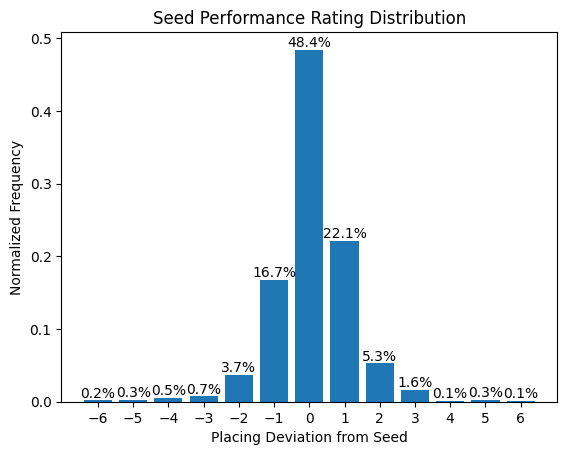

In [59]:
import matplotlib.pyplot as plt
# Get value counts and normalize
value_counts = dict(zip(*np.unique(all_placings[all_placings.series == 'nc'].spr, return_counts=True)))
total_count = sum(value_counts.values())
normalized_counts = {key: value / total_count for key, value in value_counts.items()}

# Plot histogram
plt.bar(normalized_counts.keys(), normalized_counts.values())

# Set labels and title
plt.xlabel('Placing Deviation from Seed')
plt.ylabel('Normalized Frequency')
plt.title('Seed Performance Rating Distribution')

# Set x-axis ticks
plt.xticks(list(normalized_counts.keys()))

# Add labels on top of each bar
for key, value in normalized_counts.items():
    percent = round(value * 100, 1)
    label = f'{percent}%'
    plt.text(key, value, label, ha='center', va='bottom')

# Display the plot
plt.show()

In [60]:
# Most over/under seeded
spr_df = all_placings[all_placings.series == 'nc'].groupby('player').agg({'spr':'mean', 'placing':'count'}).reset_index()
spr_df.rename(columns={'placing': 'attendance_count'}, inplace=True)
spr_df[(spr_df.attendance_count > 5) & (abs(spr_df.spr) > 0.5)].sort_values('spr')

,player,spr,attendance_count
149,kdog,-0.857143,14
134,jib,-0.733333,15
115,hatsune mitski,-0.666667,6
34,bigbuffalo,-0.636364,11
3,a horse who can drive,-0.550000,20
158,kingnut,-0.533333,15
110,gl!tch,0.550000,20
68,daniel,0.600000,10
256,snoo,0.666667,6
64,cowboy,0.666667,6


# Nightclub Upsets

In [61]:
import copy
upset_df = copy.deepcopy(sets[sets.tournament.str.contains('nightclub')])

upset_df['nightclub'] = upset_df['tournament'].str.extract(r'(s\d+e\d+)')
upset_df['loser_tag'] = np.where(upset_df['winner_tag'] == upset_df['p1_tag'],upset_df['p2_tag'],upset_df['p1_tag'])
upset_df['winner_score'] = np.where(upset_df['winner_tag'] == upset_df['p1_tag'],upset_df['p1_score'],upset_df['p2_score'])
upset_df['loser_score'] = np.where(upset_df['winner_tag'] == upset_df['p1_tag'],upset_df['p2_score'],upset_df['p1_score'])
upset_df['winner_seed'] = np.where(upset_df['winner_tag'] == upset_df['p1_tag'],upset_df['p1_seed'],upset_df['p2_seed'])
upset_df['loser_seed'] = np.where(upset_df['winner_tag'] == upset_df['p1_tag'],upset_df['p2_seed'],upset_df['p1_seed'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(upset_df[(upset_df.upset_factor >= 3)][['nightclub', 'winner_tag', 'loser_tag','winner_score','loser_score', 'winner_seed','loser_seed','upset_factor']].sort_values('upset_factor',ascending=False))

,nightclub,winner_tag,loser_tag,winner_score,loser_score,winner_seed,loser_seed,upset_factor
2558,s10e19,aidanafoo,a horse who can drive,2,0,14,1,7
535,s10e4,e-tie,tito jojo,3,1,13,2,6
1189,s10e9,cannagar,pgh fahey,3,1,12,1,6
1315,s10e10,apollo,daniel,3,2,11,1,6
2239,s10e17,bq,just jason,2,0,38,6,6
2837,s10e22,jio,bonn,2,1,39,6,6
452,s10e3,moburu,jib,2,1,16,3,5
2196,s10e16,da gobbler,stone,2,1,12,2,5
1731,s10e13,dongdysfunktion,da gobbler,2,0,51,11,5
962,s10e7,danilo calamari,e-tie,2,1,8,1,5


In [62]:
all_placings[all_placings.player == 'a horse who can drive']

,player,placing,seed,tournament,top8,series,spr,nightclub,winner_tag
31,a horse who can drive,25,27,friday-nightclub-s10e13,False,nc,0,s10e13,a horse who can drive
94,a horse who can drive,9,9,steinway-melee-5,False,other,0,NaN,a horse who can drive
129,a horse who can drive,5,7,steinway-melee-6,True,other,1,NaN,a horse who can drive
158,a horse who can drive,4,4,steinway-melee-8,True,other,0,NaN,a horse who can drive
275,a horse who can drive,65,87,the-function-4-brooklan,False,other,0,NaN,a horse who can drive
363,a horse who can drive,13,16,the-kickback-pioneers-1,False,other,0,NaN,a horse who can drive
424,a horse who can drive,25,31,the-nightclub-s10e1-os-nyc,False,nc,0,s10e1,a horse who can drive
478,a horse who can drive,17,19,the-nightclub-s10e10-os-nyc,False,nc,0,s10e10,a horse who can drive
518,a horse who can drive,17,17,the-nightclub-s10e11-os-nyc,False,nc,0,s10e11,a horse who can drive
562,a horse who can drive,13,10,the-nightclub-s10e12-os-nyc,False,nc,-1,s10e12,a horse who can drive


# PR Consideration

In [41]:
filtered_nc_placings[(filtered_nc_placings.nc_attendance <= 5) & 
                     (filtered_nc_placings.nc_attendance >= 3) & 
                    (~filtered_nc_placings.player.isin(players_to_rank)) &
                    (filtered_nc_placings.placing_mean <= 13)].sort_values(['placing_mean'], ascending=[True])

,player,all_attendance,nc_attendance,placing_mean,placing_median,placing_max,placing_min,placing_std
1,fro116,6,3,2.0,2.0,2,2,0.0
19,apollo,9,4,5.0,6.0,9,2,3.0
21,artan,5,4,6.6,7.0,13,3,4.1
33,theasianone,4,3,8.5,9.0,17,4,6.6
55,pre melon,3,3,11.5,13.0,13,9,2.3
56,rusty,5,3,11.5,13.0,13,9,2.3
62,lordtet,7,4,12.8,13.0,25,7,8.2
